# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.impute import SimpleImputer


### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [18]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

missing_percentage = dat.isnull().mean()

remove_columns = missing_percentage[missing_percentage > 0.4].index

dat = dat.drop(columns=remove_columns, axis=1)

print(dat.columns)
print(f"Final DataFrame shape: {dat.shape} ")

Index(['AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
       'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
       'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'LitterSize', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')
Final DataFrame shape: (214, 17) 


In [19]:
print(dat.columns)

Index(['AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
       'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
       'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'LitterSize', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [34]:
# Select numeric columns
numeric = dat.select_dtypes(include=np.number).columns

# Create imputer
imputer = KNNImputer(n_neighbors = 5)

# Use imputer to rewrite nas 
dat[numeric] = imputer.fit_transform(dat[numeric])

# Check the number of NAs in each dataset
nnas = (dat[numeric].isnull().sum())

print(f"The number of NAs in each column of the dat dataframe is: {nnas}")
print(f"Head of the dat data:\n {dat.head()}")

The number of NAs in each column of the dat dataframe is: AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
nClimates             0
dtype: int64
Head of the dat data:
    AdultBodyMass  Diet_Invertebrates  Diet_Vertebrates  Diet_Fruits  \
0           78.0                 1.0               0.0          1.0   
1         1082.0                 0.0               0.0          1.0   
2          946.0                 0.0               0.0          1.0   
3         1180.0                 0.0               0.0          1.0   
4         1212.5                 0.0               0.0          1.0   

   Diet_Flowers  Diet_Seeds  Diet_Plants  Diet_Other  HabitatBreadth  \
0           1.0         0.0          1.0         0.0             1.0   
1           0.0        

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [21]:
# Create value that holds the habitat sum of each row
dat['nClimates'] = dat[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)
dat = dat.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])

print(dat)

     AdultBodyMass Diet_Invertebrates Diet_Vertebrates Diet_Fruits  \
0            78.00                yes               no         yes   
1          1082.00                 no               no         yes   
2           946.00                 no               no         yes   
3          1180.00                 no               no         yes   
4          1212.50                 no               no         yes   
..             ...                ...              ...         ...   
209           8.50                yes               no          no   
210        3019.00                 no               no         yes   
211        3524.00                 no               no         yes   
212          21.80                yes              yes          no   
213          21.93                yes              yes         yes   

    Diet_Flowers Diet_Seeds Diet_Plants Diet_Other  HabitatBreadth  \
0            yes         no         yes         no             1.0   
1             no   

In [22]:
# Identify categorical columns
categorical_cols = ['Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits', 
                   'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other']

# Create mode imputer for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Fill missing values in categorical columns with mode
dat[categorical_cols] = mode_imputer.fit_transform(dat[categorical_cols])

# Convert categorical yes/no to 1/0
for col in categorical_cols:
    dat[col] = (dat[col] == 'yes').astype(int)


In [23]:
# Create X and y variables
X = dat[[
    'AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
    'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
    'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
    'LitterSize'
]]
y = dat['nClimates']  

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

Decision Tree MSE: 1.4892628293423749


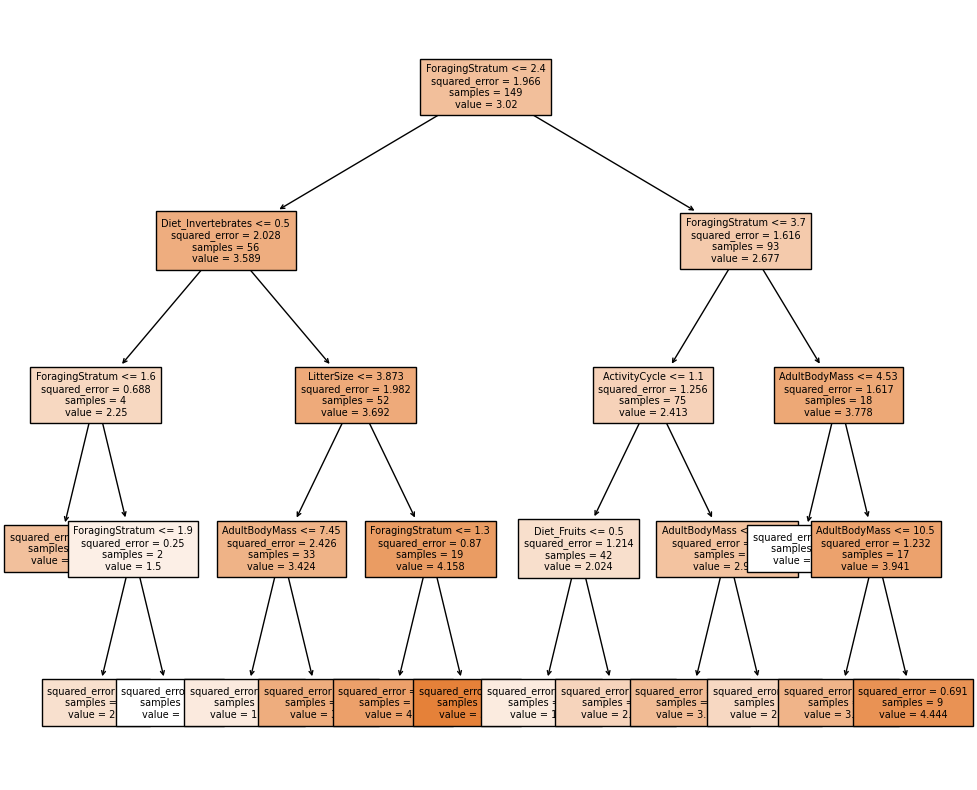

In [33]:
# Train Decision Tree with max depth of 5
tree = DecisionTreeRegressor(max_depth=4, random_state=808)
tree.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree.predict(X_test)

# Evaluate Decision Tree Model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

# Visualize Decision Tree
plt.figure(figsize=(10, 8))
plot_tree(tree, 
          feature_names=X.columns,
          filled=True,        
          proportion=False,
          fontsize=7)
plt.tight_layout() 
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

Based on the tree, I would assume foragingstratum is the most important variable.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [25]:
# Random Forest with GridSearchCV
param_grid = {
    'max_features': ['sqrt', 6, None],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=808)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to find the best combination of parameters
grid_search.fit(X_train, y_train)

# Get the best estimator and hyperparameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best hyperparameters:", best_params)

# Train the best estimator on the full training set
best_rf.fit(X_train, y_train)

# Predict on test data
y_pred = best_rf.predict(X_test)

# Evaluate performance using MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 1.4440990389576154


### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 1.4440990389576154


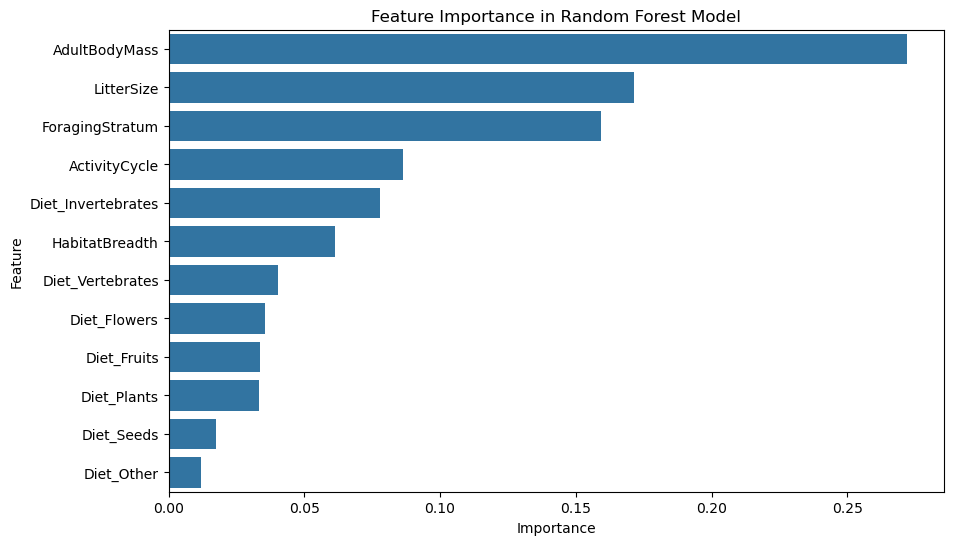

In [27]:
# Generate Predictions on X_test
y_pred = best_rf.predict(X_test)

# Print the best parameters
print("Best hyperparameters:", grid_search.best_params_)

# Compute and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Extract feature importance from the trained model
feature_importances = best_rf.feature_importances_

# Visualize feature importance using a bar plot
features = X_train.columns  #

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in Random Forest Model")
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The Random Forest ensemble model performed better, though only marginally (MSE: 1.4440 vs 1.4892) This small improvement suggests that while ensemble methods probably helped, the relationship between traits and climate adaptability might be relatively straightforward. Looking at the feature importance plot, it seems that adult body mass is the most important factor. This is somewhat unexpected to me, because I would think the diet of the animal would be highly dependent on the habitat, and having a more varied diet would help animals survive. Although I suppose it makes sense. 